## Imports

In [3]:
import h5py
from sympy import *
import numpy as np
import pandas as pd
from copy import copy,deepcopy
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import sys
import os
from PIL import Image
import json
from datetime import datetime, date, time
import cellpylib as cpl
from pybdm import BDM 
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
plt.rcParams["animation.html"] = "jshtml"

## General

In [4]:
def encodeKey(index,value):
    return "{},{}".format(index,value)

def decodeKey(key):
    return list(map(lambda x: int(x),key.split(",")))

#returns an expression to get the transformed coordinates 
# from the original dimensions to the 1 dimension flattened data
def getExpr(size):
    val = ""
    lst = []
    if len(size) > 1:
        for i in range(1,len(size)):
            temp = "xi[{}]".format(i-1)
            for j in range(i,len(size)):
                temp += "*{}".format(size[j])
            lst.append(temp)
    else:
        i = 0
    val += "+".join(lst)
    val += "+xi[{}]".format(i)
    return val


#returns an array with the position in the flattened data
#coords is an array with coordinate relative to the cell in the original dimensions
# size = np.shape(data)
def getNeighbors(cell,coords,size):
    newCoords = []
    expr = getExpr(size)
    for coord in coords:
        xi = []
        outOfBounds = False
        for i,c in enumerate(cell):
            if type(coord) != int:
                v = c+coord[i]
                if v >= size[i] or v < 0:
                    outOfBounds = True
                else:
                    xi.append(v)
            else:
                v = c+coord
                if v >= size[0] or v < 0:
                    outOfBounds = True
                else:
                    xi.append(c+coord)
        if outOfBounds:
            newCoords.append(-1)
        else:
            newCoord = eval(expr)
            newCoords.append(newCoord)
            
    return newCoords

#returns the values of the neighbors of a certain cell
#data = flattened array of the data
#neighbors = the positions of neighbors of a certain cell
#paddingtype = 0 => don't get values,1=> fill with padding value, 2 => don't fill and return empty dict
#paddingvalue = the values to fill when the padding type equals 1
def getNeighborsValue(data,neighbors,paddingType = 0,paddingValue=0):
    values = {}
    for i,n in enumerate(neighbors):
        val = None
        if n >= 0 and n < len(data):
            val = data[n]
        else:
            if paddingType == 0: continue
            elif paddingType == 1:
                val = paddingValue
            elif paddingType == 2:
                values = None
                break
        if val != None:
            values[i] = val
    return values

#returns in each iteration an array with the indexes of each dimension
def multiDimensionalGenerator(size):
    counters = np.array([size[i]-1 for i in range(len(size)-1)])
    counters = np.append(counters,size[-1])
    count = len(size)-1
    while (counters[0] >= 0):
        counters[count] -= 1
        yield [int(i) for i in counters]
        if counters[count] <= 0:
            while(counters[count] <= 0 and count > 0):
                count -= 1
            counters[count] -= 1 
            while(count+1 < len(size)):
                if count+1 == len(size)-1:
                    counters[count+1] = size[count+1]
                else:
                    counters[count+1] = size[count+1]-1
                count += 1

def manhattanDistance(arr):
    res = 0
    for i in arr:
        res += abs(i)
    return res
    
def vonNeumann(radious,distance):
    expr = lambda x: manhattanDistance(x) <= distance
    return getNeighborhood(radious,expr)
    
                
def moore(radious):
    expr = lambda x: True
    neighborhood = getNeighborhood(radious,expr)
    return neighborhood

#returns an array with the neighborhood
#expression = function to filter the neighborhood, receives a list of the indexes according to the dimension
#radious = array with the distance from each dimension                
def getNeighborhood(radious,expression):
    neighborhood = []
    spaces = []
    dimensions = len(radious)
    for i in range(dimensions):
        size = radious[i]
        spaces.append(np.arange(-size, size+1, 1))
    mesh = np.meshgrid(*spaces)
    stack = np.stack(mesh,axis=dimensions)
    stackShape = np.shape(stack)[:-1]
    for index in multiDimensionalGenerator(stackShape):
        tIndex = tuple(index)
        if expression(stack[tIndex]):
            neighborhood.append(stack[tIndex])
    for i in range(dimensions-1,-1,-1):
        neighborhood.sort(key = lambda x: x[i])
    return neighborhood

In [5]:
def errorMatrix1(original,test):
    size = np.shape(original)
    error = np.zeros(shape=size)
    for index in multiDimensionalGenerator(size):
        indTuple = tuple(index)
        error[indTuple] = 0 if original[indTuple] == test[indTuple] else 1
    return error

def errorMatrix2(original,test):
    size = np.shape(original)
    error = np.zeros(shape=size)
    for index in multiDimensionalGenerator(size):
        indTuple = tuple(index)
        error[indTuple] = abs(original[indTuple] - test[indTuple])
    return error

def error(errorMatrix):
    size = np.shape(errorMatrix)
    error = np.zeros(shape=size)
    summation = 0
    for index in multiDimensionalGenerator(size):
        indTuple = tuple(index)
        summation += errorMatrix[indTuple]
    return summation
        
#returns an array with the neighborhood
#expression = function to filter the neighborhood, receives a list of the indexes according to the dimension
#radious = array with the distance from each dimension                
def getNeighborhoodWLevels(radious,expression):
    neighborhood = {}
    spaces = []
    dimensions = len(radious)
    for i in range(dimensions):
        size = radious[i]
        spaces.append(np.arange(-size, size+1, 1))
    mesh = np.meshgrid(*spaces)
    stack = np.stack(mesh,axis=dimensions)
    stackShape = np.shape(stack)[:-1]
    for index in multiDimensionalGenerator(stackShape):
        tIndex = tuple(index)
        validNeighbor = expression(stack[tIndex])
        if validNeighbor[0]:
            if str(validNeighbor[1]) not in neighborhood:
                neighborhood[str(validNeighbor[1])] = []
            neighborhood[str(validNeighbor[1])].append(stack[tIndex])
    for k in neighborhood:
        for i in range(dimensions-1,-1,-1):
            neighborhood[k].sort(key = lambda x: x[i])
    return neighborhood
    
def mooreWLevels(radious):
    expr = lambda x: (True, np.max(np.array(np.abs(x))))
    neighborhood = getNeighborhoodWLevels(radious,expr)
    return neighborhood

def vonNeumannWLevels(radious,distance):
    expr = lambda x: (manhattanDistance(x) <= distance, manhattanDistance(x))
    return getNeighborhoodWLevels(radious,expr)

def getLearningProblemWLevels(data,neighborhood,paddingType,paddingValue):
    problem = {}
    dataSize = np.shape(data)
    stateSize = dataSize[1:]
    noStates = dataSize[0]
    for iState in range(1,noStates):
        currentState = data[iState-1].reshape(-1)
        for cell in multiDimensionalGenerator(stateSize):
            index = tuple([iState]+cell)
            cls = data[index]
            if cls not in problem:
                problem[cls] = {}
            values = {}
            for level in neighborhood:
                values[level] = []
                for neigh in neighborhood[level]:
                    if type(neigh) != list:
                        neighbors = getNeighbors(cell,[neigh],stateSize)
                    values[level].append({str(neigh): getNeighborsValue(currentState,neighbors,paddingType,paddingValue)[0] })
                    #values[level] = [values[level][key] for key in values[level]]
            problem[cls][str(values)] = values
    return problem

def information(problemWLevels,nlevels):
    info = {}
    for cls in problemWLevels:
        for level in range(nlevels):
            for key in problemWLevels[cls]:
                info[cls][level]
                
def getStr(levels,nlevels):
    res = {}
    middle = list(levels['0'][0].values())
    for i in range(1,nlevels+1): 
        i = str(i)
        left = levels[i][:(int)(len(levels[i])/2)]
        right = levels[i][(int)(len(levels[i])/2):]
        tmpleft = []
        tmpright = []
        for x in left:
            tmpleft += list(x.values())
        for x in right:
            tmpright += list(x.values())
        middle = tmpleft+copy(middle)+tmpright
        res[i] = middle
    return res

def strLevel(problem,nlevels):
    res = {}
    for cls in problem:
        res[cls] = {}
        for k in problem[cls]:
            temp = getStr(problem[cls][k],nlevels)
            for l in temp:
                if l not in res[cls]:
                    res[cls][l] = {}
                strtemp = str(temp[l])
                if strtemp not in res[cls][l]:
                    res[cls][l][strtemp] = ["",0]
                res[cls][l][strtemp][0] = temp[l]
                res[cls][l][strtemp][1] += 1 
    return res
    
def getTable(strlevels):
    tbl = {}
    for cls in strlevels:
        tbl[cls] = {}
        for lvl in strlevels[cls]:
            tbl[cls][lvl] = []
            for itm in strlevels[cls][lvl]:
                tbl[cls][lvl].append( strlevels[cls][lvl][itm])
            tbl[cls][lvl] = sorted(tbl[cls][lvl],key = lambda x:x[1],reverse = True)
    return tbl

def getTopFrequent(levels,top=10):
    mostFrequent = {}
    for cls in levels:
        mostFrequent[cls] = {}
        for lvl in levels[cls]:
            mostFrequent[cls][lvl] = levels[cls][lvl][:top]
    return mostFrequent

def getUniqueCount(levels):
    uniques = {}
    for cls in levels:
        uniques[cls] = {}
        for lvl in levels[cls]:
            uniques[cls][lvl] = 0
            for item in levels[cls][lvl]:
                if item[1] == 1:
                    uniques[cls][lvl] += 1
    return uniques

def getLevelClass(levels):
    res = {}
    for cls in levels:
        for lvl in levels[cls]:
            if lvl not in res:
                res[lvl] = {}
            for item in levels[cls][lvl]:
                itemstr = str(item[0])
                if itemstr not in res[lvl]:
                    res[lvl][itemstr] = {}
                if cls not in res[lvl][itemstr]:
                    res[lvl][itemstr][cls] = 0
                res[lvl][itemstr][cls] += item[1]
    return res


def getNeighborhoodAmbiguity(levels):
    ambiguity = {}
    for lvl in levels:
        ambiguity[lvl] = {}
        for item in levels[lvl]:
            if len(levels[lvl][item].keys()) > 1:
                ambiguity[lvl][item] = levels[lvl][item]
    return ambiguity

def getFrequencyByLocation(levels,nlstlevel):
    frequency = {}
    for cls in levels:
        frequency[cls] = {}
        for item in levels[cls][str(nlstlevel)]:
            for i,v in enumerate(item[0]):
                if i not in frequency[cls]:
                    frequency[cls][i] = {}
                if v not in frequency[cls][i]:
                    frequency[cls][i][v] = 0
                frequency[cls][i][v] += item[1]
    return frequency


def normalizeFrequency(frequency):
    normalized = {}
    for cls in frequency:
        normalized[cls] = {}
        for ind in frequency[cls]:
            normalized[cls][ind] = {}
            total = 0
            for v in frequency[cls][ind]:
                total += frequency[cls][ind][v]
            for v in frequency[cls][ind]:
                normalized[cls][ind][v] = frequency[cls][ind][v]/total
    return normalized

def getBDM(levels):
    bdm = BDM(ndim=1, nsymbols=4,raise_if_zero=False)
    res = {}
    for cls in levels:
        res[cls] = {}
        for lvl in levels[cls]:
            res[cls][lvl] = []
            for item in levels[cls][lvl]:
                tmp = np.array(item[0],dtype="int")
                #print(len(tmp))
                nbdm = 0
                try:
                    nbdm = bdm.nbdm(tmp)
                except:
                    nbdm = 0
                res[cls][lvl].append([item[0], nbdm])
            res[cls][lvl] = sorted(res[cls][lvl],key= lambda x: x[1],reverse = True)     
    return res

def getPlotFrequencies(frequencies):
    clsvals = {}
    ind = list(frequencies.keys())
    clss = list(frequencies.keys())
    for cls2 in clss:
        ind = list(frequencies[cls2].keys())
        clsvals[cls2] = {}
        for i in ind:
            for cls in clss:
                if cls not in clsvals[cls2]:
                    clsvals[cls2][cls] = []
                if cls not in frequencies[cls2][i]:
                    clsvals[cls2][cls].append(0)
                else:
                    clsvals[cls2][cls].append(frequencies[cls2][i][cls])
    for cls2 in clss:
        ind = list(frequencies[cls2].keys())
        bottoms = None
        bars = []
        subplt = plt.figure(figsize=(15,5))
        for cls in clsvals[cls2]:
            if bottoms is None:
                tmp = plt.bar(ind, clsvals[cls2][cls])
                bottoms = clsvals[cls2][cls]
            else:
                tmp = plt.bar(ind, clsvals[cls2][cls],bottom=bottoms)
                bottoms = np.sum([bottoms,clsvals[cls2][cls]],axis=0)
            bars.append(tmp)
        plt.title(cls2)
        plt.xticks(ind, ind)
        plt.legend(bars, [str(x) for x in list(clsvals[cls2].keys())])
        plt.show()

## Preprocessing

In [50]:
def dictToMat(dic):
    matrix = []
    for key in dic:
        for key2 in dic[key]:
            temp = copy(dic[key][key2])
            if type(temp) == np.ndarray:
                temp = np.append(temp,key)
            else:
                temp.append(key)
            matrix.append(temp)
    return matrix

def getDomain(data):
    #encontramos los valores observados de cada atributo en los subproblemas de aprendizaje
    domain = {}
    for row in data:
        for j,col in enumerate(row[0]):
            if j not in domain:
                domain[j] = []
            if col not in domain[j]:
                domain[j].append(col)
    for key in domain:
        domain[key].sort()
    return domain

def getPosNeg(domain,binarized):
    # obtenemos los ejemplos positivos y negativos para el atributo x[1] de los subproblemas
    keys = list(domain.keys())
    pos_neg = {}
    pos = {}
    for row in binarized:
        for val in domain[keys[-1]]:
            if val not in pos_neg:
                pos_neg[val] = {"pos":[],"neg":[]}
            if val not in pos:
                pos[val] = {}
            temp = "".join(map(str,row[:-1]))
            if val == row[-1]:
                if temp not in pos[val]:
                    pos_neg[val]["pos"].append(row[:-1])
                    pos[val][temp] = 0 
            else:
                if temp not in pos[val]:
                    pos_neg[val]["neg"].append(row[:-1])
                    pos[val][temp] = 0 
    return pos_neg

def getLearningProblem(data,neighborhood,paddingType,paddingValue):
    problem = {}
    dataSize = np.shape(data)
    stateSize = dataSize[1:]
    noStates = dataSize[0]
    for iState in range(1,noStates):
        currentState = data[iState-1].reshape(-1)
        for cell in multiDimensionalGenerator(stateSize):
            index = tuple([iState]+cell)
            cls = data[index]
            if cls not in problem:
                problem[cls] = {}
            neighbors = getNeighbors(cell,neighborhood,stateSize)
            values = getNeighborsValue(currentState,neighbors,paddingType,paddingValue)
            values = [values[key] for key in values]
            strvalues = str(values)
            if strvalues not in problem[cls]:
                problem[cls][strvalues] = [None,0]
            problem[cls][str(values)][0] = values
            problem[cls][str(values)][1] += 1
    return problem

def getFrequency(matrix):
    frequency = {}
    for row in matrix:
        cls = row[2]
        for i,col in enumerate(row[0]):
            if i not in frequency:
                frequency[i] = {"total":{}}
            if col not in frequency[i]:
                frequency[i][col] = {}
            if cls not in frequency[i][col]:
                frequency[i][col][cls] = 0
            if cls not in frequency[i]["total"]:
                frequency[i]["total"][cls] = 0
            frequency[i][col][cls] += row[1]
            if col != -1:
                frequency[i]["total"][cls] += row[1]
            
    return frequency

## Rule Testing

In [790]:
# it's a generator that returns one step of the evolution each time
# neighborhood = an array with a relative neighborhood
# initialState = an array with the initial state
# noSteps = the number of steps of the evolution
# size = np.shape(data)
# paddingtype = 0 => don't get values,1=> fill with padding value, 2 => don't fill and return empty dict
# paddingvalue = the values to fill when the padding type equals 1
def ruleTestingGenerator(rules,neigborhood,initialState,noSteps,size,paddingType,paddingValue):
    initialState = initialState.reshape(-1)
    currentStep = copy(initialState)
    for step in range(noSteps):
        nextStep = copy(currentStep)#np.zeros(shape=np.shape(currentStep))
        for cell in multiDimensionalGenerator(size):
            neighbors = getNeighbors(cell,neigborhood,size)
            A = getNeighborsValue(currentStep,neighbors,paddingType,paddingValue)
            for op in rules:
                if rules[op] != "":
                    res = eval(rules[op])
                    if res:
                        xi = cell
                        tmpCell = eval(getExpr(size))
                        nextStep[tmpCell] = op
        yield step,nextStep
        currentStep = nextStep

## Model

In [882]:
class GAModel():
    def __init__(self,examples,frequency,populationSize,antMinSize,antMaxSize,objAttrInd,domain,seed=-1):
        self.examples = examples
        self.frequency = frequency
        self.populationSize = populationSize
        self.antMinSize = antMinSize
        self.antMaxSize = antMaxSize
        self.objAttrInd = objAttrInd
        self.domain = domain
        self.seed = seed
        self.noChilds = 10
        self.noIterations = 50
        self.k = 2
        
    def getCompletness(self,fit):
        res = {}
        for cls in fit:
            res[cls] = 0
            mx = -1
            kmx = 0
            gkmx = 0
            for vals in fit[cls]:
                if vals != "total":
                    if fit[cls][vals] > mx:
                        mx = fit[cls][vals]
                        kmx = vals
                    if vals > gkmx:
                        gkmx = vals
            total = 0
            start = kmx
            for i in range(kmx,gkmx+1):
                if i > 0:
                    start = i
                if i in fit[cls] and i >0:
                    total += fit[cls][i]
            res[cls] = {start: total/fit[cls]["total"]}
        return res
    
    def getSoundness(self,fit):
        res = {}
        for cls in fit:
            res[cls] = 0
            kmx = 0
            for vals in fit[cls]:
                if vals != "total":
                    if vals > kmx:
                        kmx = vals
            res[cls] = {kmx: fit[cls][kmx]/fit[cls]["total"]}
        return res
    
    #returns for each class the total number of genes that match with the number of examples per class
    def matchingExamples(self,ind):
        res = {}
        for el in self.examples:
            cls = el[2]
            example = el[0]
            if cls not in res:
                res[cls] = {"total":0}
            total = 0
            for gen in ind[0]:
                if type(gen[1]) == set:
                    if example[gen[0]] != -1:
                        if example[gen[0]] in gen[1]:
                            total += 1
                    else:
                        total += 1/len(self.domain[gen[0]]) # this means that any value in the gen value match when we not have information 
                                    # in the example
                else:
                    if example[gen[0]] != -1:
                        if gen[1] != -1:
                            if example[gen[0]] == gen[1]:
                                total += 1
                    else:
                        total += 1/len(self.domain[gen[0]])
            total = round(total)
            res[cls]["total"] += el[1]
            if total not in res[cls]:
                res[cls][total] = 0
            res[cls][total] += el[1]
                
        return res
                    
                
    # returns from each gen in the chromosome the total number of examples per class that match with the value
    # in that gen divided by the total number of examples per class that has a value in that position
    def matchingGenes(self,ind):
        res = {}
        for gen in ind[0]:
            res[gen[0]] = {}
            if type(gen[1]) == set:
                for el in gen[1]:
                    if el in self.frequency[gen[0]]:
                        for cls in self.frequency[gen[0]][el]:
                            if cls not in res[gen[0]]:
                                res[gen[0]][cls] = 0
                            total = self.frequency[gen[0]]["total"][cls] if self.frequency[gen[0]]["total"][cls] > 0 else 1
                            res[gen[0]][cls] += self.frequency[gen[0]][el][cls]/total
                        
            else:
                if gen[1] == -1:
                    res[gen[0]][-1] = -1
                else:
                    if gen[1] not in self.frequency[gen[0]]:
                        res[gen[0]][-1] = 0
                    else:
                        for cls in self.frequency[gen[0]][gen[1]]:
                            if cls not in self.frequency[gen[0]][gen[1]]:
                                res[gen[0]][cls] = 0
                            total = self.frequency[gen[0]]["total"][cls] if self.frequency[gen[0]]["total"][cls] > 0 else 1
                            res[gen[0]][cls] = self.frequency[gen[0]][gen[1]][cls] / total
        return res
    
    def metric1(self,completness,soundness,ind):
        res = {}
        for cls in completness:
            res[cls] = 0
            for key in completness[cls]:
                res[cls] += completness[cls][key] * (key/len(ind[0]))
            for key in soundness[cls]:
                res[cls] += soundness[cls][key] * (key/len(ind[0]))
            res[cls] = res[cls]/2
        return res
    
    def metric2(self,fit1,fit3):
        res = {}
        total = {}
        for col in fit1:
            for cls in fit1[col]:
                if cls not in res:
                    res[cls] = 0
                    total[cls] = 0
                res[cls] += fit1[col][cls]
                total[cls] += 1
        for cls in total:
            res[cls] = res[cls]/total[cls]
        for cls in fit3:
            if cls not in res:
                res[cls] = fit3[cls]
            else:
                res[cls] = res[cls] * fit3[cls]
        return res
    
    def getMaxVal(self,fit4):
        kmx = list(fit4.keys())[0]
        for k in fit4:
            if fit4[k] > fit4[kmx]:
                kmx = k
        return (kmx,fit4[kmx])
    
    def fitness(self,ind):
        fit1 = self.matchingGenes(ind)
        fit2 = self.matchingExamples(ind)
        completness = self.getCompletness(fit2)
        soundness = self.getSoundness(fit2)
        fit3 = self.metric1(completness,soundness,ind)
        fit4 = self.metric2(fit1,fit3)
        
        return self.getMaxVal(fit4),fit1
    
    def initialize(self):
        population = []
        for i in range(self.populationSize):
            antSize = random.randint(self.antMinSize,self.antMaxSize)
            ant = [[i,-1] for i in range(len(self.domain))]
            for j in range(antSize):
                attr = random.randint(0,len(self.domain)-1)
                val = random.randint(-1,max(self.domain[attr]))
                if val != -1:
                    ant[attr][1] = set([val])
                else:
                    ant[attr][1] = val
            valC = random.randint(min(self.domain[self.objAttrInd]),max(self.domain[self.objAttrInd]))
            cons = [self.objAttrInd,valC]
            population.append([ant,cons])
        return population
    
    def splitByGroup(self,fitnessTbl):
        groups = {}
        for el in fitnessTbl:
            cls = el[0][0][0]
            if cls not in groups:
                groups[cls] = []
            groups[cls].append(el)
        return groups
    
    def tournament(self,group):
        best = None
        for i in range(self.k+1):
            ind = random.randint(0, len(group)-1)
            if (best == None) or group[ind][0][0][1] > group[best][0][0][1]:
                best = ind
        return group[best]

    def getFitness(self,population):
        fitnessTbl = []
        for i,ind in enumerate(population):
            fitnessTbl.append([self.fitness(ind),ind])
        fitnessTbl = sorted(fitnessTbl,key = lambda x: x[0][0][1],reverse = True)
        return fitnessTbl
    
    def getChilds(self,p1,p2):
        cls = p1[0][0][0]
        chromosome1 = p1[1]
        chromosome2 = p2[1]
        fit1 = p1[0][1]
        fit2 = p2[0][1]
        child1 = [[],[1,cls]]
        ant = []
        for pair in zip(chromosome1[0],chromosome2[0]):
            gen = pair[0]
            gen2 = pair[1]
            if cls in fit1[gen[0]] and cls in fit2[gen[0]]:
                if fit1[gen[0]][cls] > fit2[gen[0]][cls]:
                    ant.append([gen[0],gen[1]])
                elif fit1[gen[0]][cls] < fit2[gen[0]][cls]:
                    ant.append([gen2[0],gen2[1]])
                else:
                    newSet = set()
                    for x in pair:
                        if type(x[1]) == set:
                            for val in x[1]:
                                newSet.add(val)
                        else:
                            newSet.add(x[1])
                    ant.append([gen[0],newSet])
            elif cls not in fit1[gen[0]]:
                ant.append([gen[0],gen2[1]])
            elif cls not in fit2[gen[0]]:
                ant.append([gen[0],gen[1]])
            else:
                ant.append([gen[0],gen[1]])
        child1[0] = ant
                
        return child1
    
    def getProbOn(self,cls):
        res = []
        total = 0
        for col in self.frequency:
            total1 = 0
            count = 0
            for val in self.frequency[col]:
                total2 = 0
                if val != -1:
                    for cs in self.frequency[col][val]:
                        total2 += self.frequency[col][val][cs]
                    if cls in self.frequency[col][val]:
                        count+= 1
                        total1+= self.frequency[col][val][cls]/total2
                else:
                    if cls in self.frequency[col][val]:
                        count+= 1 
            total += total1/count
            res.append([col,total1/count])
        res = [[x[0],x[1]/total] for x in res]
        return res
    
    def mutation1(self,ind,cls):
        ant = [[x[0],x[1]] for x in ind[0]]
        mutated = [ant,[1,cls]]
        rnd = random.random()
        prob = self.getProbOn(cls)
        prob = sorted(prob,key=lambda x: x[1],reverse= True)
        i = 0
        ptotal = 0
        for p in prob:
            ptotal += p[1]
            if rnd <= ptotal:
                i = p[0]
                break
        if mutated[0][i][0] == -1:
            ival = random.randint(0,len(self.domain[i]))
            mutated[0][i][1] = self.domain[i][ival]
        return mutated
    
    def mutation2(self,ind,cls):
        ant = [[x[0],x[1]] for x in ind[0]]
        mutated = [ant,[1,cls]]
        rnd = random.random()
        prob = self.getProbOn(cls)
        prob = sorted(prob,key=lambda x: x[1])
        i = 0
        ptotal = 0
        for p in prob:
            ptotal += 1-p[1]
            if rnd <= ptotal:
                i = p[0]
                break
        if mutated[0][i][1] != -1:
            mutated[0][i][1] = -1
        return mutated
    
    def getProbRemove(self,col,val,cls):
        total = 0
        if val not in self.frequency[col]:
            return 0
        for x in self.frequency[col][val]:
            total += self.frequency[col][val][x]
        if cls in self.frequency[col][val]:
            return (self.frequency[col][val][cls]/total)
        return 0
    
    def getNewSet(self,vals,col,cls):
        nset = set()
        probs = []
        for val in vals:
            probs.append([val,self.getProbRemove(col,val,cls)])
        probs = sorted(probs,key = lambda x:x[1])
        total = 0
        for x in probs:
            total += x[1]
        if total <= 0:
            total = 100000
        probs = [[x[0],x[1]/total] for x in probs]
        rnd = random.random()
        t = 0
        for x in probs:
            t += x[1]
            if rnd < t:
                nset.add(x[0])
            else:
                ival = random.randint(0,len(self.domain[col])-1)
                if self.domain[col][ival] != -1:
                    nset.add(self.domain[col][ival])
        return nset
    
    def mutation3(self,ind,cls):
        ant = [[x[0],x[1]] for x in ind[0]]
        mutated = [ant,[1,cls]]
        for gen in mutated[0]:
            if type(gen[1]) == set:
                if len(gen[1]) > 1:
                    nset = self.getNewSet(gen[1],gen[0],cls)
                    gen[1] = nset
                else:
                    nset = set()
                    for el in gen[1]:
                        nset.add(el)
                    ival = random.randint(0,len(self.domain[gen[0]])-1)
                    if self.domain[gen[0]][ival] != -1:
                        nset.add(self.domain[gen[0]][ival])
                    gen[1] = nset
        return mutated
    
    def mutate(self,ind,cls):
        mutated = []
        mutated.append(self.mutation1(ind,cls))
        mutated.append(self.mutation2(ind,cls))
        mutated.append(self.mutation3(ind,cls))
        
        return mutated
    
    def crossover(self,parents):
        childs = []
        for i in range(0,len(parents),2):
            p1 = parents[i]
            p2 = parents[i+1]
            childs.append(self.getChilds(p1,p2))
            
        return childs
            
    def getParents(self,group):
        parents = []
        for i in range(self.noChilds*2):
            parents.append(self.tournament(group))
        return parents
            
    def evolution(self,fitnessTbl):
        groups = self.splitByGroup(fitnessTbl)
        for i in range(self.noIterations):
            childs = []
            for group in groups:
                parents = self.getParents(groups[group])
                childs += self.crossover(parents)
            fitnessTbl = self.getFitness(childs)
            childsGroup = self.splitByGroup(fitnessTbl)
            mutated = []
            for group in childsGroup:
                mutated += self.mutate(childsGroup[group][0][1],group)
                mutated += self.mutate(childsGroup[group][-1][1],group)
            fitnessTbl = self.getFitness(mutated)
            mutatedGroup = self.splitByGroup(fitnessTbl)
            for group in childsGroup:
                if group not in groups:
                    groups[group] = []
                groups[group] += childsGroup[group]
                groups[group] += mutatedGroup[group]
                groups[group] = sorted(groups[group],key = lambda x: x[0][0][1],reverse = True)
                mid = floor(len(groups[group])/2)
                groups[group] = [] + groups[group][0:5] + groups[group][mid:5] + [groups[group][-1]]
                
            yield groups
    
    def run(self):
        if self.seed != -1:
            random.seed(self.seed)
        population = self.initialize()
        fitnessTbl = self.getFitness(population)
        
        return fitnessTbl

## Test

In [230]:
dataframe = pd.read_csv("data/2_square.csv")

In [394]:
dataframe.values

array([[1, 1, 3, 0, 0, 0, 0, 0],
       [1, 4, 5, 0, 0, 0, 0, 0],
       [4, 6, 2, 1, 0, 0, 0, 0],
       [7, 1, 5, 1, 0, 0, 0, 0],
       [1, 7, 2, 6, 0, 0, 0, 0],
       [1, 2, 3, 1, 1, 0, 0, 0],
       [1, 3, 5, 1, 1, 0, 0, 0],
       [0, 5, 2, 6, 1, 0, 0, 0],
       [0, 2, 5, 1, 6, 0, 0, 0],
       [0, 2, 2, 6, 1, 1, 0, 0],
       [0, 2, 2, 1, 6, 1, 0, 0],
       [0, 2, 2, 1, 1, 6, 0, 0],
       [0, 2, 2, 1, 1, 1, 1, 0],
       [0, 2, 2, 1, 1, 1, 1, 0],
       [0, 2, 2, 1, 1, 1, 1, 0],
       [0, 2, 2, 1, 1, 1, 1, 0],
       [0, 2, 2, 1, 1, 1, 1, 0]])

In [684]:
radious = 2
neighborhood = moore([radious])
neighborhoodWLevels = mooreWLevels([radious])
paddingType = 1
paddingValue = -1
antMaxSize = (radious*2)+1
antMinSize = 2
populationSize = 100

In [685]:
problem = getLearningProblem(dataframe.values,neighborhood,paddingType,paddingValue)
matrix = dictToMat(problem)
domain = getDomain(matrix)
goalAttr = list(domain.keys())[-1]
freq = getFrequency(matrix)

In [883]:
model = GAModel(matrix,freq,populationSize,antMinSize,antMaxSize,goalAttr,domain)

In [884]:
evol = model.run()

In [869]:
x = enumerate(model.evolution(evol))

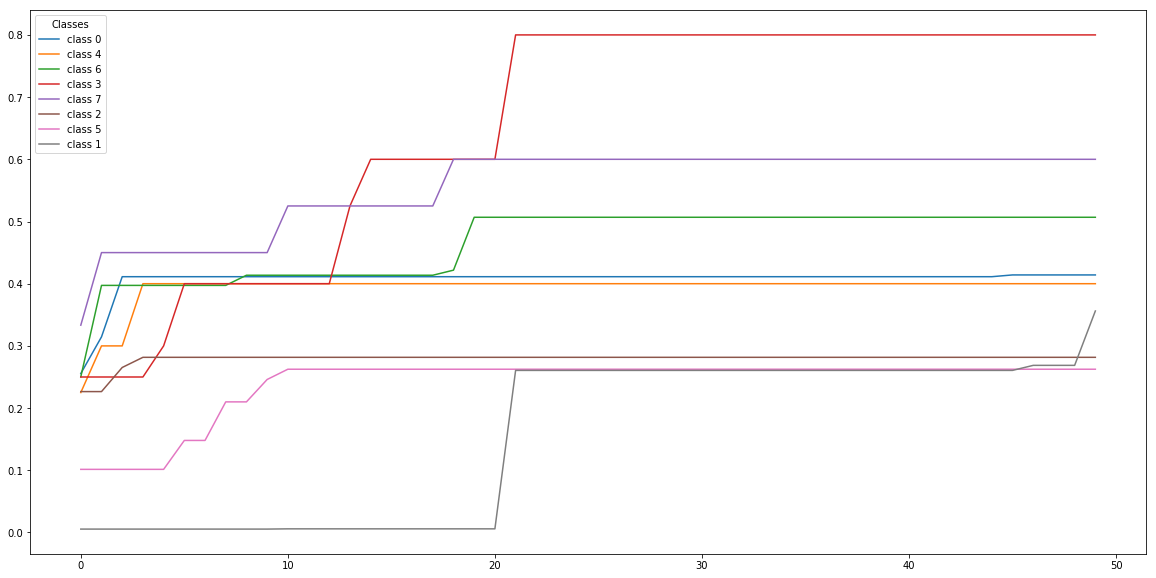

In [885]:
history = {}
for j,i in enumerate(model.evolution(evol)): 
    for cls in i:
        if cls not in history:
            history[cls] = []
        history[cls].append([i[cls][0][0][0][1],i[cls][0][1]])
plt.figure(figsize=(20,10))
for cls in history:
    fit = np.array(history[cls])[:,0]
    plt.plot(range(len(fit)),fit,label="class {}".format(cls))
plt.legend(title='Classes')

In [886]:
print(np.array(history[7])[:,1])

[list([[[0, -1], [1, {2, 7}], [2, -1], [3, {4, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, -1], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, -1], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, -1], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, -1], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, -1], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, -1], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, -1], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, -1], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, -1], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, {4, 6}], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, {4, 6}], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -1], [1, {2, 7}], [2, {4, 6}], [3, {5, 6}], [4, {1, 2}]], [1, 7]])
 list([[[0, -

In [392]:
matrix

[[[0, 0, 0, -1, -1], 9, 0],
 [[0, 0, 0, 0, -1], 5, 0],
 [[0, 0, 0, 0, 0], 2, 0],
 [[3, 0, 0, 0, 0], 1, 0],
 [[1, 3, 0, 0, 0], 1, 0],
 [[5, 0, 0, 0, 0], 1, 0],
 [[1, 0, 0, 0, 0], 2, 0],
 [[2, 1, 0, 0, 0], 1, 0],
 [[5, 1, 0, 0, 0], 1, 0],
 [[6, 0, 0, 0, 0], 1, 0],
 [[1, 0, 0, 0, -1], 3, 0],
 [[1, 1, 0, 0, 0], 2, 0],
 [[-1, -1, 1, 3, 5], 1, 0],
 [[6, 1, 0, 0, 0], 1, 0],
 [[-1, -1, 0, 5, 2], 1, 0],
 [[6, 0, 0, 0, -1], 1, 0],
 [[-1, -1, 0, 2, 5], 1, 0],
 [[1, 0, 0, -1, -1], 2, 0],
 [[1, 1, 0, 0, -1], 1, 0],
 [[-1, -1, 0, 2, 2], 7, 0],
 [[6, 1, 0, 0, -1], 1, 0],
 [[6, 0, 0, -1, -1], 1, 0],
 [[1, 1, 0, -1, -1], 4, 0],
 [[1, 1, 3, 0, 0], 1, 5],
 [[4, 6, 2, 1, 0], 1, 5],
 [[1, 2, 3, 1, 1], 1, 5],
 [[-1, 1, 3, 5, 1], 1, 5],
 [[0, 5, 2, 6, 1], 1, 5],
 [[-1, 1, 1, 3, 0], 1, 4],
 [[-1, -1, 1, 4, 5], 1, 4],
 [[-1, -1, 1, 1, 3], 1, 1],
 [[4, 5, 0, 0, 0], 1, 1],
 [[6, 2, 1, 0, 0], 1, 1],
 [[-1, 4, 6, 2, 1], 1, 1],
 [[-1, -1, 7, 1, 5], 1, 1],
 [[2, 6, 0, 0, 0], 1, 1],
 [[7, 2, 6, 0, 0], 1, 1],
 [[-1, -